# Model selection

Cross-validation is used here to select the best model. In this script it is used to test the best machine learning model for use in this context.

<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* XGBoost
* Extra Trees Regressor

<u> The following variables are included in the model:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables (within a 500m buffer of the sensor):
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   

In [1]:
# !pip install -q scikit-learn-extra

In [15]:
import sklearn_extra
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster import cluster_visualizer
from sklearn.cluster import KMeans

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import geopy.distance
from sklearn.model_selection import TimeSeriesSplit
import time as time
import sklearn_extra
from sklearn_extra.cluster import KMedoids

from Functions import *

#https://goldinlocks.github.io/Time-Series-Cross-Validation/ 
class BlockingTimeSeries_withSpatial_Split():
    def __init__(self, n_temporal_splits, n_spatial_clusters):
        self.n_temporal_splits = n_temporal_splits
        self.n_spatial_clusters = n_spatial_clusters
        
    def get_n_splits(self, X, y, groups):
        return self.n_temporal_splits
    
    def get_n_spatial_splits(self, X, y, groups):
        return self.n_spatial_clusters  
    
    @staticmethod
    def check_training_index_in_cluster(training_idx, X, training_clusters):
        cluster_num = X.iloc[training_idx]['Cluster_num_5clusters']
        # If this cluster number is in the spatial training set, add to training indices list for this cluster
        if cluster_num in training_clusters:
            return training_idx
        else:
            return None
        
    def run_cluster_analysis(X, start, stop, melbourne_sensors, n_spatial_clusters):
            # Get list of sensors which have data in this time block
            list_sensors_this_timeslice = X.iloc[start :stop]['sensor_id'].unique().tolist()
            # Get dataframe containing coordinates for these sensors
            melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)].copy()
            coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   

            # Initialize KMeans instance
            kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
            # coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

            # Join back to dataframe of sensors in this timeslice
            melbourne_sensors_in_this_timeslice['Cluster_number'] = kmeans.labels_
            
            # Join this onto Xfull (so now all rows with that sensor_id will show as being in that cluster)
            # Including rows not within this timeslice, but this shouldn't matter
            Xfull = pd.merge(Xfull, melbourne_sensors_in_this_timeslice, on='sensor_id', how='left')
            
            return Xfull
            
    
    def split(self, X, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_temporal_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        # I think the margin is about leaving a space between folds
        margin = 0
        
        ###############################################################
        ###############################################################
        # For each of the temporal folds
        ###############################################################
        ###############################################################
        for temporal_i in range(self.n_temporal_splits):
            print(f"Temporal split number {temporal_i}")

            # Find the start, and end index of the temporal split
            start = temporal_i * k_fold_size
            stop = start + k_fold_size
            print(start,stop)
            # Find the mid point of this split (where the testing data stops and training starts)
            mid = int(0.9 * (stop - start)) + start
            # Get the indices equating to the rows which will be in the training and testing portions for this temporal split
            training_indices = pd.Series (indices[start: mid])
            test_indices =pd.Series(indices[mid + margin: stop])
            
            print(f"Start: {X['datetime'][start]}, end: {X['datetime'][stop]}")
            
            ###############################################################
            ###############################################################
            # For the portion of data being used in this timeslice (incl. both testing and training):
                # 
            ###############################################################
            ###############################################################
            # Get list of sensors which have data in this timeslice
            list_sensors_this_timeslice = X.iloc[start :end]['sensor_id'].unique().tolist()
            # Get dataframe containing coordinates for these sensors
            melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)]
            coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   
            
            # Initialize KMeans instance
            kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
            coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_
            
            ###############################################################
            ###############################################################
            # Create n_spatial_clusters versions of this temporal fold
            # In each case only using the training rows found within n_spatial_clusters - 1 of the clusters
            # and only keeping testing rows found within the other row
            ###############################################################
            ###############################################################
            # For each of the spatial clusters
            for spatial_i in range(len(list(range(0,self.n_spatial_clusters)))):
                print(f"Spatial split number {spatial_i}")
                
                # For this spatial iteration, create lists to store the training and testing indices 
                this_cluster_trainingindices = []
                this_cluster_testingindices = []

                # For this spatial iteration, define the clusters which will be used in testing and training
                training_clusters = list(range(0,self.n_spatial_clusters))
                training_clusters.pop(spatial_i)
                testing_clusters = [spatial_i]
                
                # Find the indices of rows which 
                this_cluster_trainingindices = X.iloc[training_indices][X.iloc[training_indices]['Cluster_num_5clusters'].isin(training_clusters)].index.values.tolist()
                this_cluster_testingindices = X.iloc[test_indices][X.iloc[test_indices]['Cluster_num_5clusters'].isin(testing_clusters)].index.values.tolist()
                
                #print(f"Clusters {training_clusters} being used here in training. "
                #      f"There are {len(this_cluster_trainingindices)} rows of training data in this cluster")
                      
                print(f"Clusters {testing_clusters} being used here in testing. "
                     f"There are {len(this_cluster_testingindices)} rows of testing data in this cluster")
                
                print(f"Testing data is {round((len(this_cluster_testingindices)/len(this_cluster_trainingindices))*100,1)}"
                      f"% of training data")
                
                yield np.array(this_cluster_trainingindices), np.array(this_cluster_testingindices)

### Get cluster numbers

In [39]:
# cluster_numbers = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")[['sensor_id','Cluster_num_5clusters']]

### Get data

In [4]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [11]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

### Add sensor id and use this to add on the cluster number

In [13]:
Xfull[['sensor_id', "datetime"]] = pd.read_csv(input_csv)[['sensor_id','datetime']]
# Xfull = pd.merge(Xfull, cluster_numbers, on='sensor_id', how='left')

### Testing

In [30]:
test2 = pd.merge(Xfull,test, on='sensor_id', how='left')
test2

,year,Temp,Humidity,Pressure,Rain,WindSpeed,Rainfall amount (millimetres),public_holiday,school_holiday,betweenness,...,direction_1,direction_2,Latitude,Longitude,location,Start,End,Values_per_sensor,Cluster_num_5clusters,Cluster_number
0,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0.024056,...,South,North,-37.822935,144.947175,"(-37.82293543, 144.94717511)",2011.0,2022.0,102265.0,3.0,3.0
1,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0.041181,...,East,West,-37.813807,144.965167,"(-37.81380667, 144.96516719)",2011.0,2022.0,103483.0,1.0,4.0
2,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0.014960,...,South,North,-37.810644,144.964471,"(-37.81064378, 144.96447132)",2011.0,2021.0,84404.0,1.0,4.0
3,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0.032700,...,East,West,-37.813449,144.973053,"(-37.81344861, 144.97305354)",2011.0,2022.0,98871.0,1.0,0.0
4,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0.009190,...,East,West,-37.819830,144.951026,"(-37.81982992, 144.95102556)",2011.0,2022.0,103457.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129077,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,0.026441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4129078,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,0.021752,...,East,West,-37.811729,144.968247,"(-37.81172913, 144.9682466)",2013.0,2022.0,79243.0,1.0,4.0
4129079,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,0.038697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4129080,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,0.005675,...,East,West,-37.812372,144.965507,"(-37.81237202, 144.96550671)",2013.0,2022.0,78475.0,1.0,4.0


In [31]:
def run_cluster_analysis(X, start, stop, melbourne_sensors, n_spatial_clusters):
        # Get list of sensors which have data in this time block
        list_sensors_this_timeslice = X.iloc[start :stop]['sensor_id'].unique().tolist()
        # Get dataframe containing coordinates for these sensors
        melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)].copy()
        coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()   

        # Initialize KMeans instance
        kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)
        # coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_

        # Join back to dataframe of sensors in this timeslice
        melbourne_sensors_in_this_timeslice['Cluster_number'] = kmeans.labels_

        # Join this onto Xfull (so now all rows with that sensor_id will show as being in that cluster)
        # Including rows not within this timeslice, but this shouldn't matter
        Xfull = pd.merge(Xfull, melbourne_sensors_in_this_timeslice, on='sensor_id', how='left')

        return Xfull

In [27]:
test = run_cluster_analysis(X=Xfull, start = 0 , stop  =1032270, melbourne_sensors= melbourne_sensors, n_spatial_clusters=5)

In [69]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)
melbourne_sensors = melbourne_sensors.drop_duplicates('sensor_id', keep='first')

if 'Start' not in  melbourne_sensors.columns:
    sensors_dates_covered = pd.read_csv("../Cleaned_data/SensorData/sensors_dates_covered.csv")
    melbourne_sensors = pd.merge(melbourne_sensors, sensors_dates_covered, on='sensor_id',  how='left')

len(melbourne_sensors)

91

In [136]:
list_sensors_this_timeslice = Xfull.iloc[0 :1032270]['sensor_id'].unique().tolist()
melbourne_sensors_in_this_timeslice = melbourne_sensors[melbourne_sensors['sensor_id'].isin(list_sensors_this_timeslice)]
coordinates_to_cluster = melbourne_sensors_in_this_timeslice[['Latitude','Longitude']].copy()

### Kmediods clustering

In [6]:
# kmedoids = KMedoids(n_clusters=n_spatial_clusters, random_state=0).fit(np.array(coordinates_to_cluster))
# np.unique(kmedoids.labels_, return_counts=True)

In [ ]:
# initial_medoids = np.random.choice(len(np.array(coordinates_to_cluster)), 3, replace=False).tolist()
# kmedoids_instance = kmedoids(np.array(coordinates_to_cluster), initial_medoids)
# # Run K-Medoids clustering
# kmedoids_instance.process()
# clusters = kmedoids_instance.get_clusters()

# visualizer = cluster_visualizer()
# visualizer.append_clusters(clusters, np.array(coordinates_to_cluster).tolist())
# visualizer.show()

In [154]:
# def balance_clusters(clusters, desired_size=None):
#     """Balance the size of clusters by moving points from larger clusters to smaller ones."""
#     if desired_size is None:
#         desired_size = sum(len(cluster) for cluster in clusters) // len(clusters)

#     overflow = []  # Points that are in clusters that are too large
#     underflow = []  # Clusters that are too small

#     for cluster in clusters:
#         while len(cluster) > desired_size:
#             overflow.append(cluster.pop())
#         while len(cluster) < desired_size:
#             underflow.append(cluster)

#     for point in overflow:
#         underflow[0].append(point)
#         if len(underflow[0]) == desired_size:
#             underflow.pop(0)

#     return clusters

# # Balance the clusters
# balanced_clusters = balance_clusters(clusters)

# # Visualize the balanced clusters
# visualizer = cluster_visualizer()
# visualizer.append_clusters(balanced_clusters, X.tolist())
# visualizer.show()

### K means clustering

In [ ]:
# Initialize KMeans instance
kmeans = KMeans(n_clusters=n_spatial_clusters, random_state=0).fit(coordinates_to_cluster)

In [124]:
coordinates_to_cluster['Kmeans_clusternum'] = kmeans.labels_
coordinates_to_cluster['Kmediods_clusternum'] = kmedoids.labels_

In [125]:
coordinates_to_cluster.to_csv("timeperiod1.csv", index=False)

In [ ]:
Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00
Start: 2015-12-25 23:00:00, end: 2018-11-17 10:00:00
Start: 2018-11-17 10:00:00, end: 2021-01-25 04:00:00
Start: 2021-01-25 04:00:00, end: 2022-10-31 23:00:00

In [60]:
# Create the BlockedTimeSeriesSplit object
n_temporal_blocks=4
btss = BlockingTimeSeriesSplit(n_temporal_splits=n_temporal_blocks, n_spatial_clusters = 5)

In [61]:
# Plot the fold indices
for fold, (train_index, test_index) in enumerate(btss.split(Xfull)):
    pass

Temporal split number 0
0 1032270
Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00
Spatial split number 0
Clusters [0] being used here in testing. There are 10486 rows of testing data in this cluster
Testing data is 1.2% of training data
Spatial split number 1
Clusters [1] being used here in testing. There are 59923 rows of testing data in this cluster
Testing data is 17.1% of training data
Spatial split number 2
Clusters [2] being used here in testing. There are 0 rows of testing data in this cluster
Testing data is 0.0% of training data
Spatial split number 3


KeyboardInterrupt: 

Temporal split number 0
Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00
Spatial split number 0
Clusters [1, 2, 3, 4] being used here in training. There are 840600 rows of training data in this cluster
Clusters [0] being used here in testing. There are 10486 rows of testing data in this cluster
Testing data is 1.2% of training data


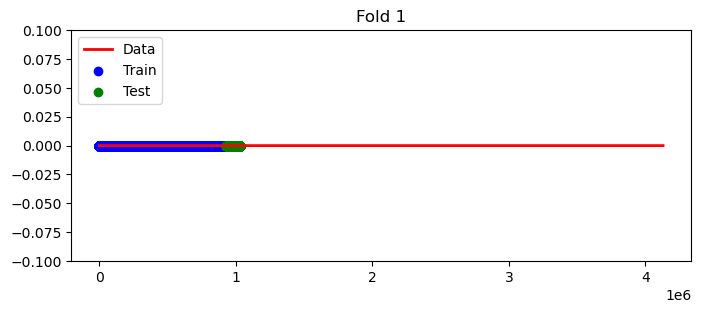

Spatial split number 1
Clusters [0, 2, 3, 4] being used here in training. There are 351004 rows of training data in this cluster
Clusters [1] being used here in testing. There are 59923 rows of testing data in this cluster
Testing data is 17.1% of training data


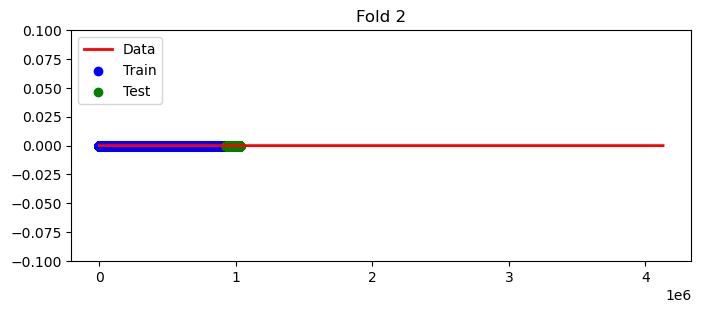

Spatial split number 2
Clusters [0, 1, 3, 4] being used here in training. There are 929043 rows of training data in this cluster
Clusters [2] being used here in testing. There are 0 rows of testing data in this cluster
Testing data is 0.0% of training data


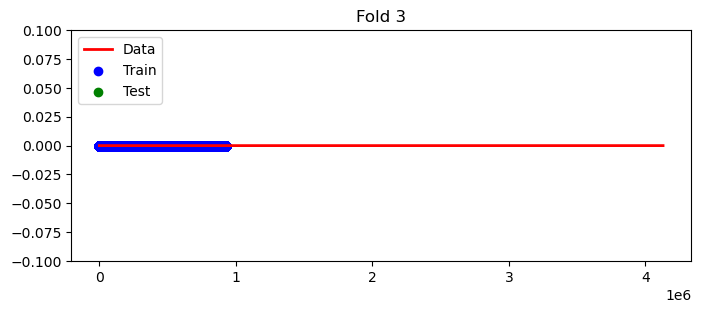

Spatial split number 3
Clusters [0, 1, 2, 4] being used here in training. There are 769042 rows of training data in this cluster
Clusters [3] being used here in testing. There are 11041 rows of testing data in this cluster
Testing data is 1.4% of training data


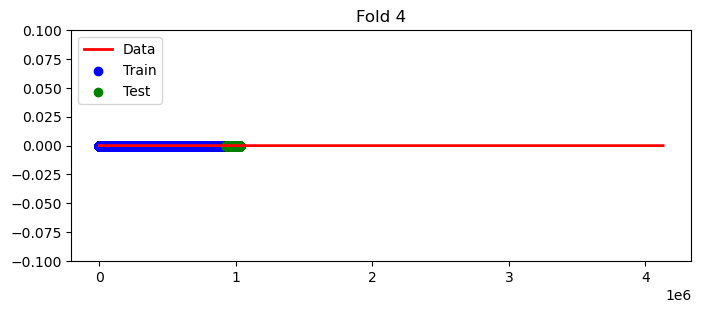

Spatial split number 4
Clusters [0, 1, 2, 3] being used here in training. There are 826483 rows of training data in this cluster
Clusters [4] being used here in testing. There are 21777 rows of testing data in this cluster
Testing data is 2.6% of training data


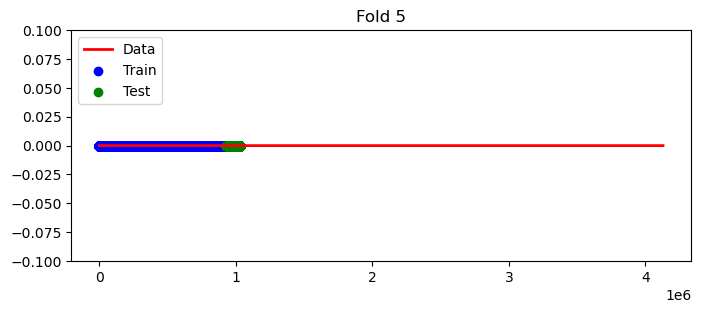

Temporal split number 1
Start: 2015-12-25 23:00:00, end: 2018-11-17 10:00:00
Spatial split number 0
Clusters [1, 2, 3, 4] being used here in training. There are 844155 rows of training data in this cluster
Clusters [0] being used here in testing. There are 8797 rows of testing data in this cluster
Testing data is 1.0% of training data


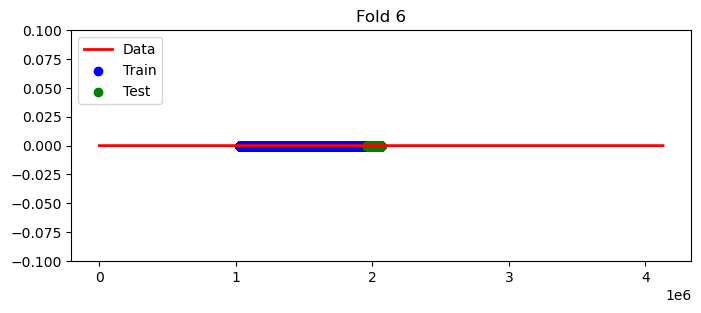

Spatial split number 1
Clusters [0, 2, 3, 4] being used here in training. There are 387786 rows of training data in this cluster
Clusters [1] being used here in testing. There are 56995 rows of testing data in this cluster
Testing data is 14.7% of training data


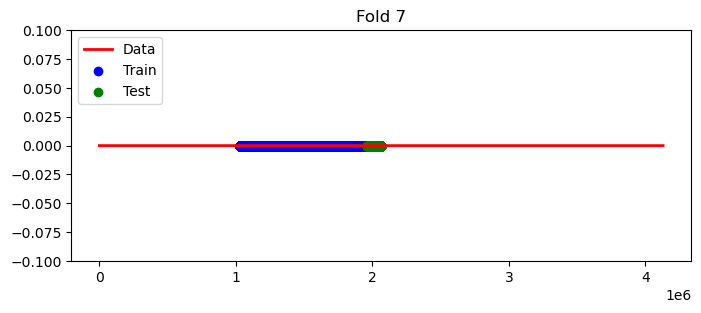

Spatial split number 2
Clusters [0, 1, 3, 4] being used here in training. There are 929043 rows of training data in this cluster
Clusters [2] being used here in testing. There are 0 rows of testing data in this cluster
Testing data is 0.0% of training data


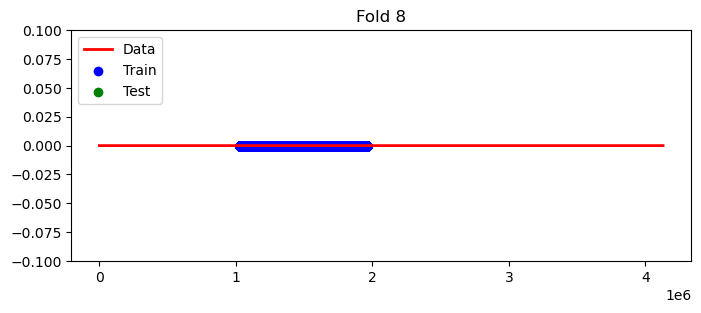

Spatial split number 3
Clusters [0, 1, 2, 4] being used here in training. There are 838429 rows of training data in this cluster
Clusters [3] being used here in testing. There are 9831 rows of testing data in this cluster
Testing data is 1.2% of training data


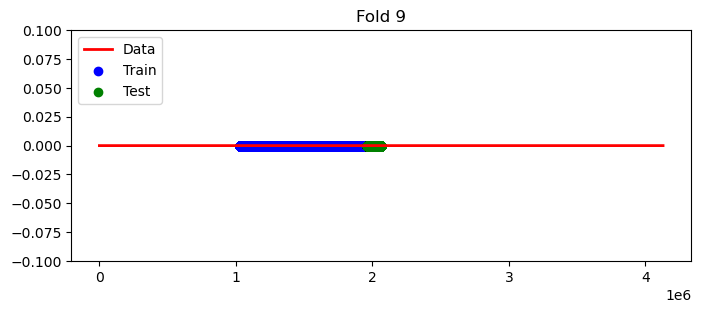

Spatial split number 4
Clusters [0, 1, 2, 3] being used here in training. There are 716759 rows of training data in this cluster
Clusters [4] being used here in testing. There are 27604 rows of testing data in this cluster
Testing data is 3.9% of training data


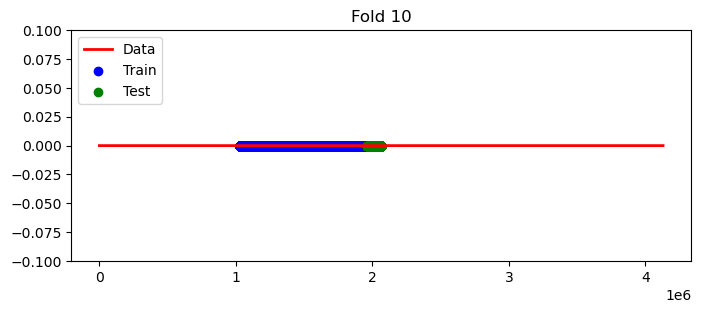

Temporal split number 2
Start: 2018-11-17 10:00:00, end: 2021-01-25 04:00:00
Spatial split number 0
Clusters [1, 2, 3, 4] being used here in training. There are 850671 rows of training data in this cluster
Clusters [0] being used here in testing. There are 9003 rows of testing data in this cluster
Testing data is 1.1% of training data


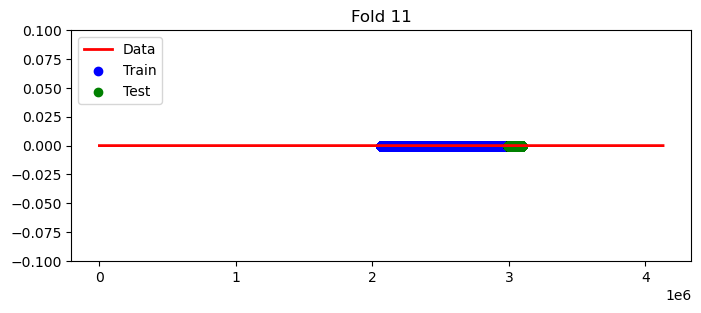

Spatial split number 1
Clusters [0, 2, 3, 4] being used here in training. There are 438718 rows of training data in this cluster
Clusters [1] being used here in testing. There are 56222 rows of testing data in this cluster
Testing data is 12.8% of training data


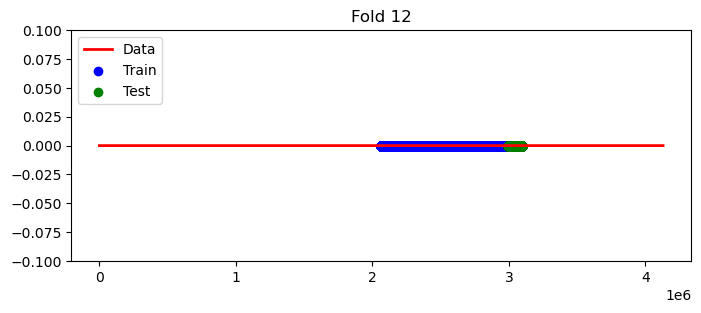

Spatial split number 2
Clusters [0, 1, 3, 4] being used here in training. There are 929043 rows of training data in this cluster
Clusters [2] being used here in testing. There are 0 rows of testing data in this cluster
Testing data is 0.0% of training data


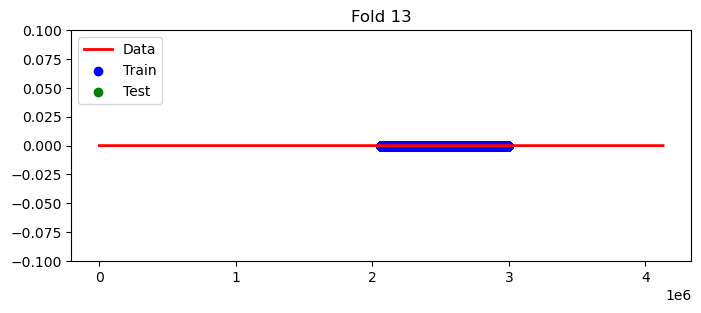

Spatial split number 3
Clusters [0, 1, 2, 4] being used here in training. There are 844630 rows of training data in this cluster
Clusters [3] being used here in testing. There are 8021 rows of testing data in this cluster
Testing data is 0.9% of training data


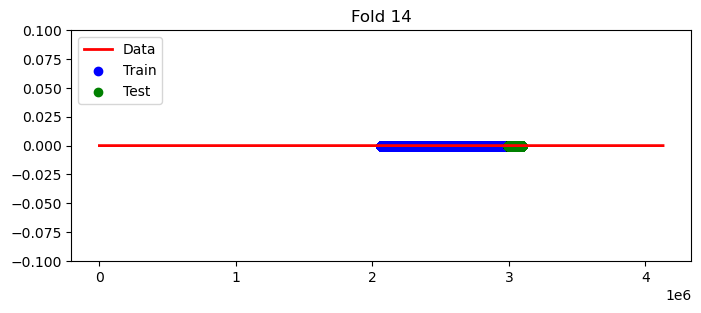

Spatial split number 4
Clusters [0, 1, 2, 3] being used here in training. There are 653110 rows of training data in this cluster
Clusters [4] being used here in testing. There are 29981 rows of testing data in this cluster
Testing data is 4.6% of training data


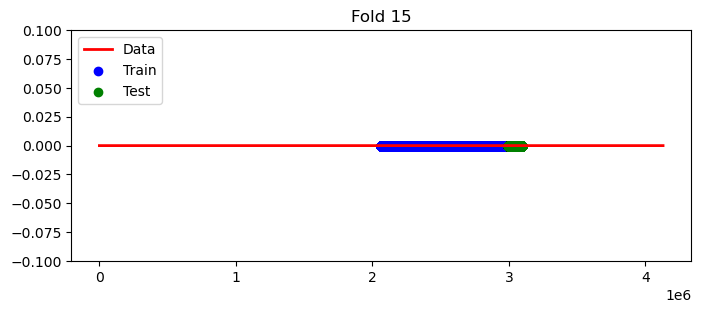

Temporal split number 3
Start: 2021-01-25 04:00:00, end: 2022-10-31 23:00:00
Spatial split number 0
Clusters [1, 2, 3, 4] being used here in training. There are 857987 rows of training data in this cluster
Clusters [0] being used here in testing. There are 7581 rows of testing data in this cluster
Testing data is 0.9% of training data


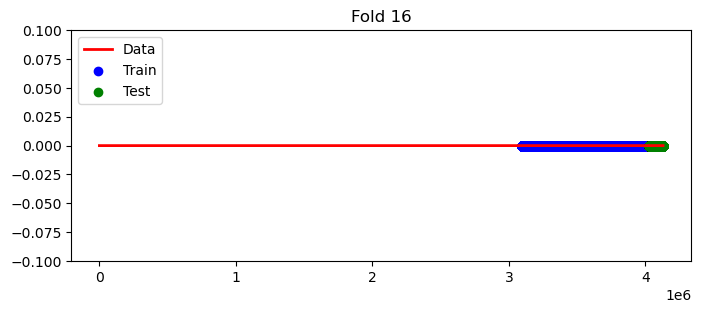

Spatial split number 1
Clusters [0, 2, 3, 4] being used here in training. There are 437827 rows of training data in this cluster
Clusters [1] being used here in testing. There are 50836 rows of testing data in this cluster
Testing data is 11.6% of training data


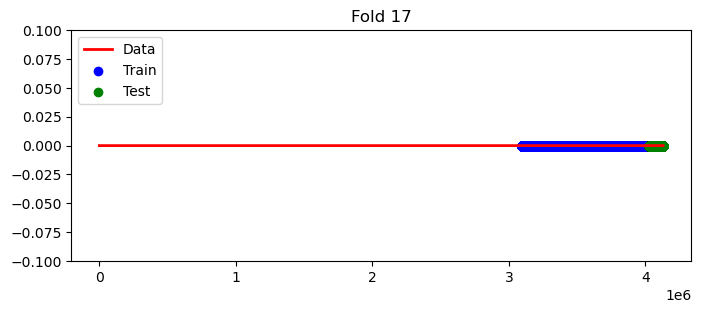

Spatial split number 2
Clusters [0, 1, 3, 4] being used here in training. There are 910231 rows of training data in this cluster
Clusters [2] being used here in testing. There are 3124 rows of testing data in this cluster
Testing data is 0.3% of training data


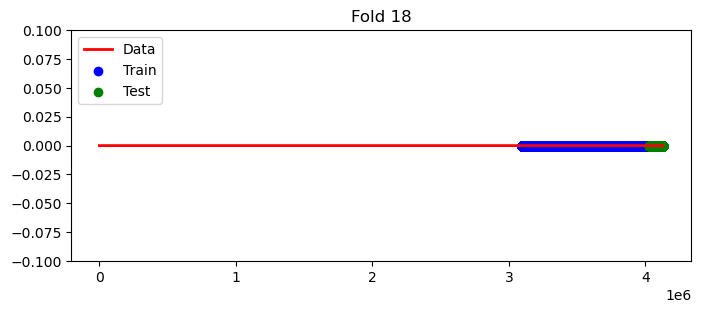

Spatial split number 3
Clusters [0, 1, 2, 4] being used here in training. There are 837715 rows of training data in this cluster
Clusters [3] being used here in testing. There are 10808 rows of testing data in this cluster
Testing data is 1.3% of training data


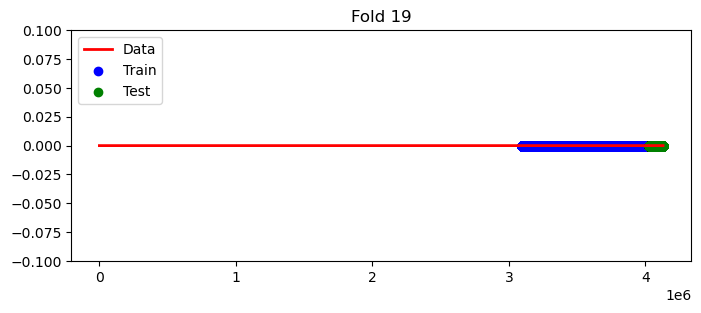

Spatial split number 4
Clusters [0, 1, 2, 3] being used here in training. There are 672412 rows of training data in this cluster
Clusters [4] being used here in testing. There are 30878 rows of testing data in this cluster
Testing data is 4.6% of training data


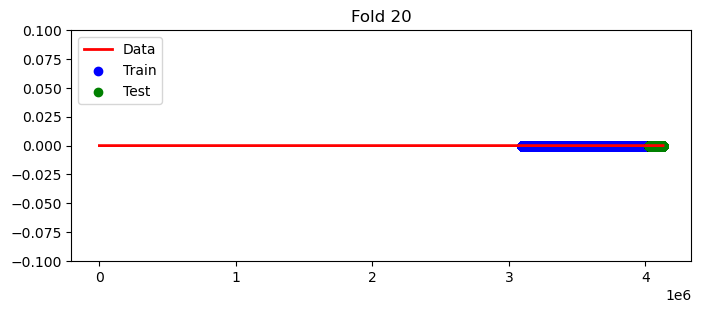

In [49]:
# Plot the fold indices
for fold, (train_index, test_index) in enumerate(btss.split(Xfull)):
    plt.figure(figsize=(8, 3))
    plt.plot(np.arange(len(Yfull)), np.zeros_like(Yfull), 'r-', lw=2, label='Data')
    plt.scatter(train_index, np.zeros_like(train_index), c='b', marker='o', label='Train')
    plt.scatter(test_index, np.zeros_like(test_index), c='g', marker='o', label='Test')
    plt.title(f'Fold {fold+1}')
    plt.legend(loc='upper left')
    plt.ylim(-0.1, 0.1)
    plt.show()

In [46]:
print(f"Start: {Xfull['datetime'][0]}, end: {Xfull['datetime'][1032270]}")

Start: 2011-01-01 00:00:00, end: 2015-12-25 23:00:00


## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [14]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)
cv_parameters = btscv = BlockingTimeSeriesSplit(n_splits=10)

In [15]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

In [16]:
models_dict = {"rf_regressor":rf_model_pipeline,
               "linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline
              }

### Prepare data for modelling

In [41]:
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [43]:
# Add sensor_ids
sensor_ids = pd.read_csv(input_csv)['sensor_id']
Xfull['sensor_id'] = sensor_ids

In [44]:
# Join to the cluster number (for cross validation)
test = Xfull.merge(cluster_numbers, on=['sensor_id'], how='left')

### Remove year

In [ ]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [ ]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

### Run model with cross validation

In [62]:
models_dict = {"rf_regressor":rf_model_pipeline}

In [80]:
# Create the BlockedTimeSeriesSplit object
n_temporal_blocks=10
btss = BlockingTimeSeriesSplit(n_splits=n_temporal_blocks)

In [48]:
cv_parameters = BlockingTimeSeriesSplit(n_splits=10)
# cv_parameters =  KFold(n_splits=10, random_state=1, shuffle=True)
# cv_parameters = TimeSeriesSplit(n_splits=10)

In [63]:
# Create the BlockedTimeSeriesSplit object
btss = BlockingTimeSeriesSplit(n_splits=3)
# Perform cross-validation with spatial and temporal blocking
for train_temporal_index, test_temporal_index in btss.split(X):
    print(train_temporal_index, test_temporal_index)

[      0       1       2 ... 1238721 1238722 1238723] [1238724 1238725 1238726 ... 1376357 1376358 1376359]
[1376360 1376361 1376362 ... 2615081 2615082 2615083] [2615084 2615085 2615086 ... 2752717 2752718 2752719]
[2752720 2752721 2752722 ... 3991441 3991442 3991443] [3991444 3991445 3991446 ... 4129077 4129078 4129079]


In [65]:
# Dataframe to store the scores for all the models
#error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

rf_regressor
Ran in 4 minutes


### Print table showing error metrics associated with each model

In [68]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,100.29,2.631653e+15,0.75,199.69
rf_regressor,58.35,1.438735e+15,0.94,120.87
rf_regressor,100.29,2.631653e+15,0.75,199.69
